<a href="https://colab.research.google.com/github/AbbyYang22/Oil-IndexBasedPricing/blob/main/ContractPrice_long_term.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import display
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import random
from IPython.display import display
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from math import sqrt
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
pip install arch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# My packages
import statsmodels
import itertools
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.api import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
import arch

In [ ]:
import warnings
#warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore") # specify to ignore warning messages

#Dataset

## Prepare the daily data

In [ ]:
benchmark = "wti"  # can be 'wti' or 'brent'
aggregation = "daily"  # can be 'daily', 'weekly', 'monthly' or 'year'
source_csv = f"https://raw.githubusercontent.com/datasets/oil-prices/master/data/{benchmark}-{aggregation}.csv"
df_wti = pd.read_csv(source_csv)

In [ ]:
benchmark = "brent"  # can be 'wti' or 'brent'
aggregation = "daily"  # can be 'daily', 'weekly', 'monthly' or 'year'
source_csv = f"https://raw.githubusercontent.com/datasets/oil-prices/master/data/{benchmark}-{aggregation}.csv"
df_brent = pd.read_csv(source_csv)

In [ ]:
rbob_source = f'https://raw.githubusercontent.com/jcarlson1001/rbob/main/New_York_Harbor_Reformulated_RBOBcsv.csv'
df_rbob = pd.read_csv(rbob_source)

In [ ]:
def preparedata_daily(df):
  # don't want to have to remember cases
  df.columns = df.columns.str.lower()

  # a more explicit method
  df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

  #Using the Time Series Index
  df.set_index('date', inplace=True)

  return df

In [ ]:
df_wti = preparedata_daily(df_wti)
df_brent = preparedata_daily(df_brent)
df_rbob = preparedata_daily(df_rbob)

In [ ]:
df_crude = (
    pd.merge(pd.merge(df_wti, df_brent, left_index=True, right_index=True), df_rbob, left_index=True, right_index=True)
    .rename(columns={'price_x':'wti', 'price_y':'brent', 'price':'rbob'})
)
df_crude

,wti,brent,rbob
date,,,
2005-10-03,65.36,61.64,1.889
2005-10-04,63.74,59.17,1.845
2005-10-05,62.56,59.33,1.765
2005-10-06,61.81,57.20,1.720
2005-10-07,61.81,57.29,1.740
...,...,...,...
2023-05-02,71.71,76.71,2.436
2023-05-03,68.62,72.91,2.322
2023-05-04,68.52,73.00,2.326


In [ ]:
df_crude.isnull().sum()

wti      0
brent    0
rbob     0
dtype: int64

## Prepare the weekly data

In [ ]:
benchmark = "wti"  # can be 'wti' or 'brent'
aggregation = "weekly"  # can be 'daily', 'weekly', 'monthly' or 'year'
source_csv = f"https://raw.githubusercontent.com/datasets/oil-prices/master/data/{benchmark}-{aggregation}.csv"
df_wti_weekly = pd.read_csv(source_csv)

In [ ]:
benchmark = "brent"  # can be 'wti' or 'brent'
aggregation = "weekly"  # can be 'daily', 'weekly', 'monthly' or 'year'
source_csv = f"https://raw.githubusercontent.com/datasets/oil-prices/master/data/{benchmark}-{aggregation}.csv"
df_brent_weekly = pd.read_csv(source_csv)

In [ ]:
rbob_source = f'https://raw.githubusercontent.com/jcarlson1001/rbob/main/New_York_Harbor_Reformulated_RBOBcsv.csv'
df_rbob = pd.read_csv(rbob_source)

In [ ]:
def preparedata_weekly(df):
  # don't want to have to remember cases
  df.columns = df.columns.str.lower()

  # a more explicit method
  df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
  #df['weekly'] = df['date'].dt.strftime("%Y%W")
  df['week'] = pd.to_datetime(df['date'], format = '%Y%W').dt.strftime('%Y-%W')
  df = df.groupby(by=['week'], as_index=False).mean()

  #Using the Time Series Index
  df.set_index('week', inplace=True)

  return df

In [ ]:
df_wti_weekly = preparedata_weekly(df_wti_weekly)
df_brent_weekly = preparedata_weekly(df_brent_weekly)
df_rbob_weekly = preparedata_weekly(df_rbob)

In [ ]:
df_crude_weekly = (
    pd.merge(pd.merge(df_wti_weekly, df_brent_weekly, left_index=True, right_index=True), df_rbob_weekly, left_index=True, right_index=True)
    .rename(columns={'price_x':'wti', 'price_y':'brent', 'price':'rbob'})
)
df_crude_weekly

,wti,brent,rbob
week,,,
2005-40,63.06,58.93,1.7918
2005-41,62.87,58.59,1.7418
2005-42,62.28,58.15,1.6704
2005-43,61.33,58.50,1.6244
2005-44,60.34,58.74,1.5968
...,...,...,...
2023-15,81.87,87.36,2.8428
2023-16,79.22,84.62,2.6718
2023-17,76.31,81.40,2.5762


In [ ]:
df_crude_weekly.isnull().sum()

wti      0
brent    0
rbob     0
dtype: int64

# Exploratory Data Analysis
Use Box-Jenkins time series analysis

## 1. Plot the time series data vs time

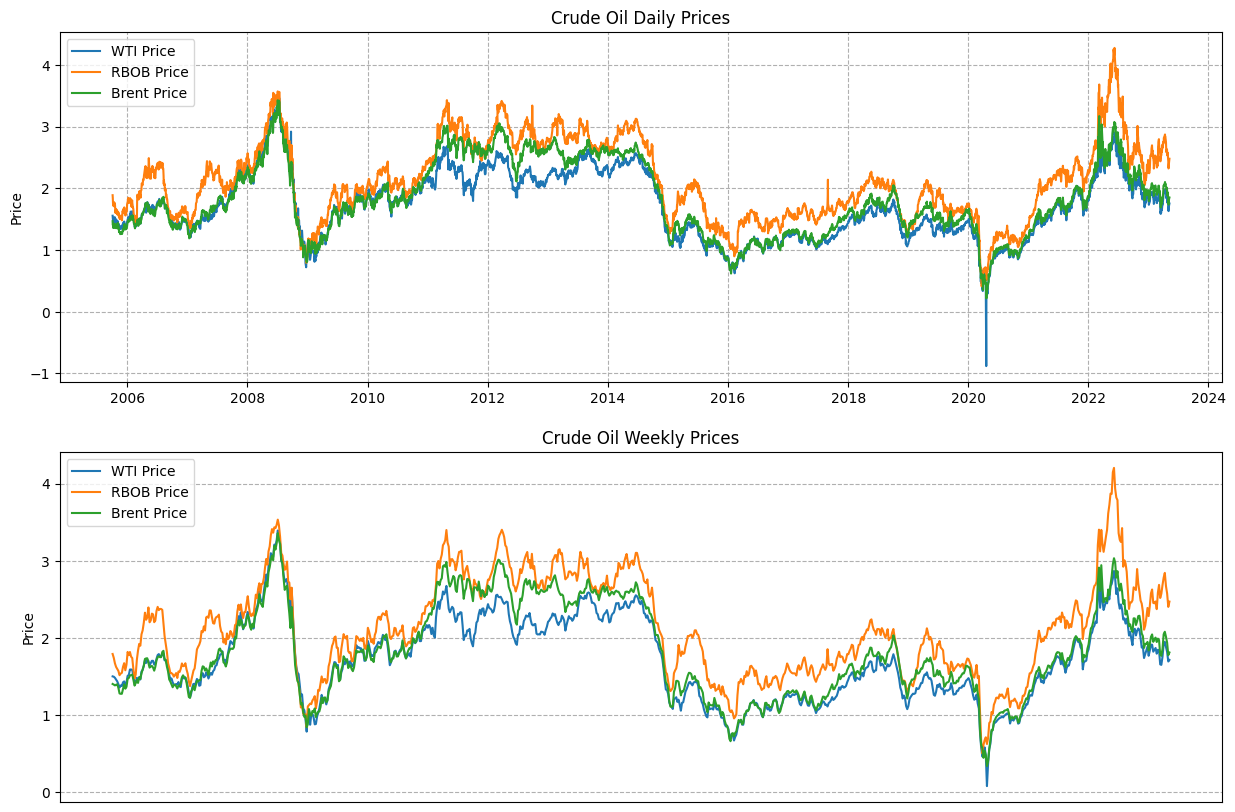

In [ ]:
plt.figure(figsize=(15,10))

plt.subplot(2, 1, 1)
plt.plot(df_crude.index, df_crude.wti/42, label='WTI Price')
plt.plot(df_crude.index, df_crude.rbob, label='RBOB Price')
plt.plot(df_crude.index, df_crude.brent/42, label='Brent Price')
plt.ylabel('Price')
plt.title('Crude Oil Daily Prices')
plt.grid(linestyle='--')
plt.legend(loc='best')

plt.subplot(2, 1, 2)
plt.plot(df_crude_weekly.index, df_crude_weekly.wti/42, label='WTI Price')
plt.plot(df_crude_weekly.index, df_crude_weekly.rbob, label='RBOB Price')
plt.plot(df_crude_weekly.index, df_crude_weekly.brent/42, label='Brent Price')
#plt.xlabel('Week')
plt.ylabel('Price')
plt.title('Crude Oil Weekly Prices')
plt.xticks(())
plt.grid(linestyle='--')
plt.legend(loc='best')

plt.show()

## 2. Statistics

In [ ]:
print('Daily')
df_crude.describe(include='all')

Daily


,wti,brent,rbob
count,4376.000000,4376.000000,4376.000000
mean,72.114292,76.652991,2.122945
std,22.529912,25.226698,0.633604
min,-36.980000,9.120000,0.412000
25%,53.917500,57.685000,1.614000
50%,70.255000,72.275000,2.056500
75%,90.882500,100.330000,2.644000
max,145.310000,143.950000,4.276000


In [ ]:
print('Weekly')
df_crude_weekly.describe(include='all')

Weekly


,wti,brent,rbob
count,916.000000,916.000000,916.000000
mean,72.097904,76.649138,2.123466
std,22.478259,25.212828,0.634107
min,3.320000,14.240000,0.504200
25%,53.817500,57.897500,1.612500
50%,70.215000,72.310000,2.047900
75%,90.977500,100.490000,2.643650
max,142.520000,141.070000,4.204200


## 3. Decomposition

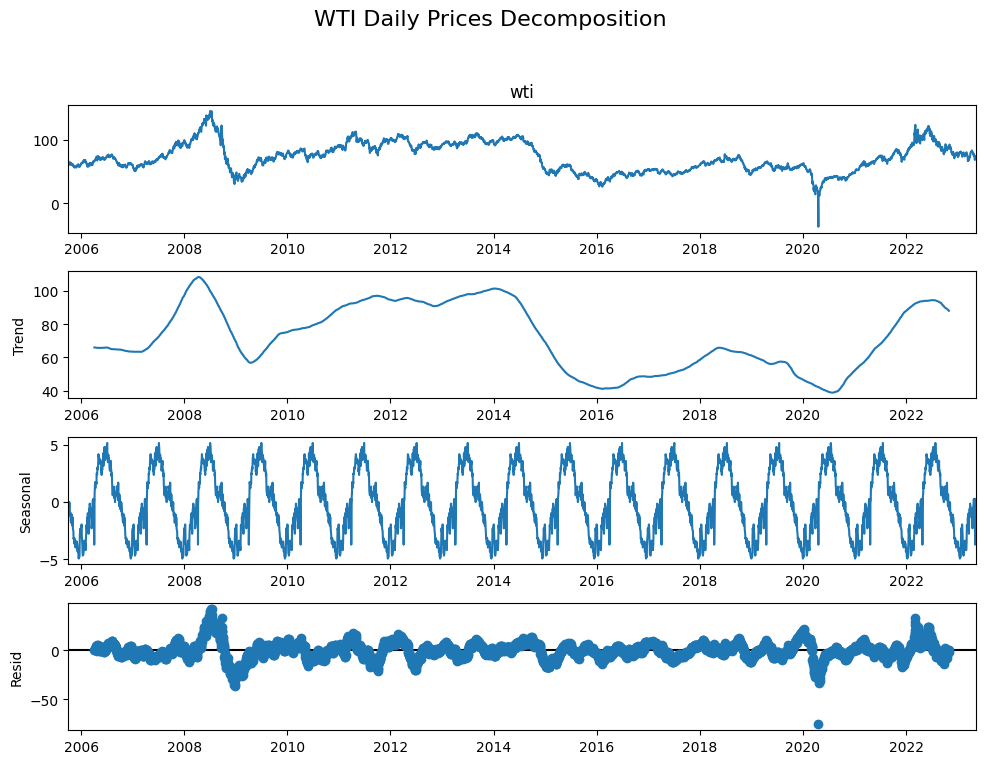

In [ ]:
# Decomposition
result = seasonal_decompose(df_crude.wti, period=250)

# Plot
plt.rcParams.update({'figure.figsize': (10,8)})
result.plot().suptitle('WTI Daily Prices Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

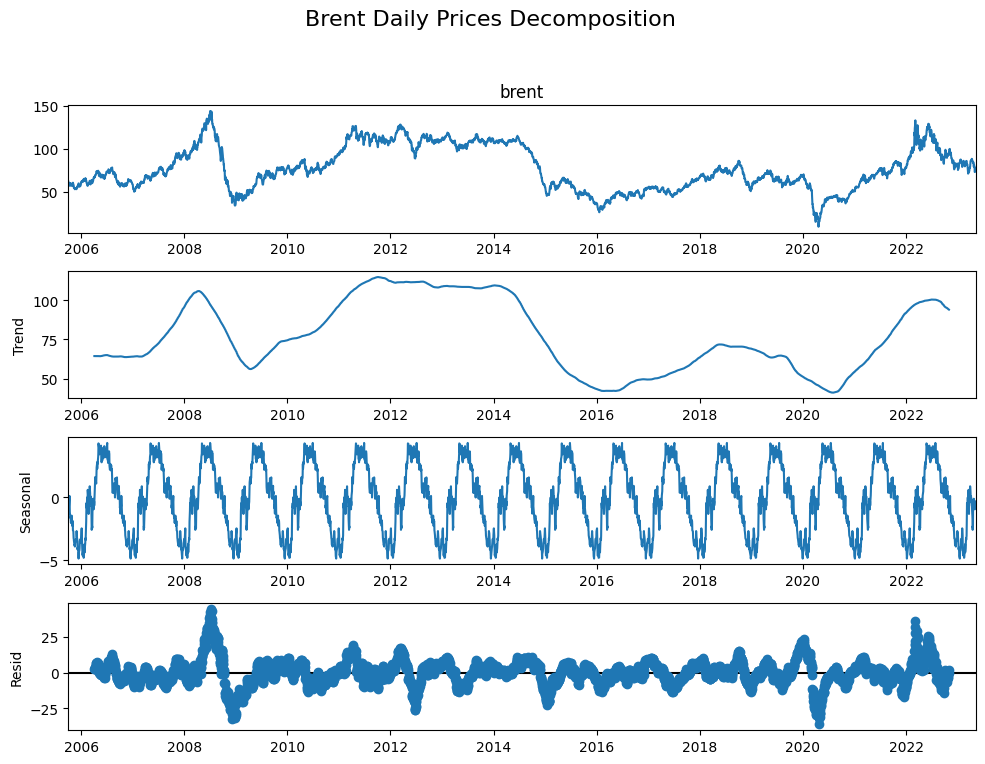

In [ ]:
# Decomposition
result = seasonal_decompose(df_crude.brent, period=250)

# Plot
plt.rcParams.update({'figure.figsize': (10,8)})
result.plot().suptitle('Brent Daily Prices Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## 4. Check Normality

### Daily

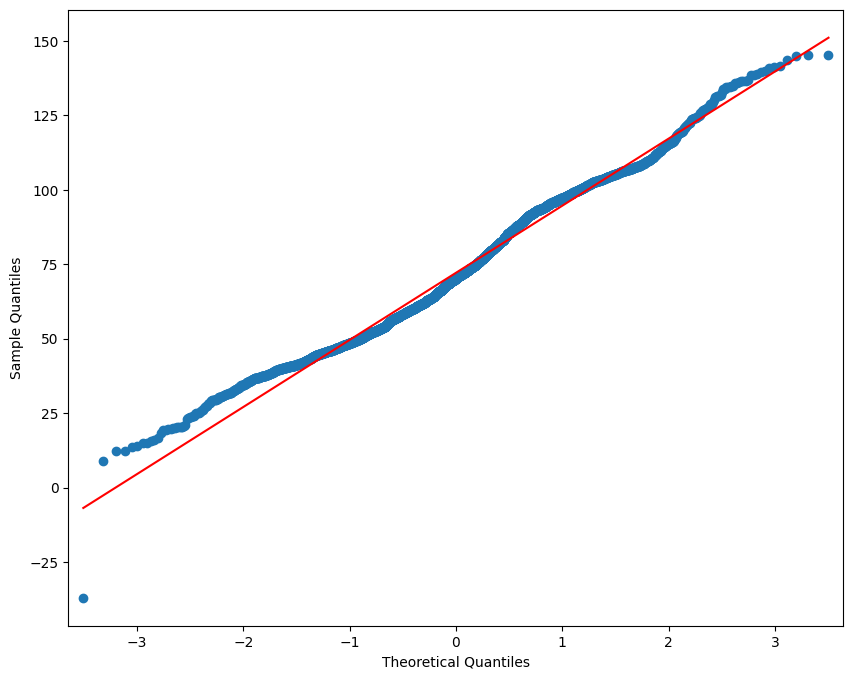

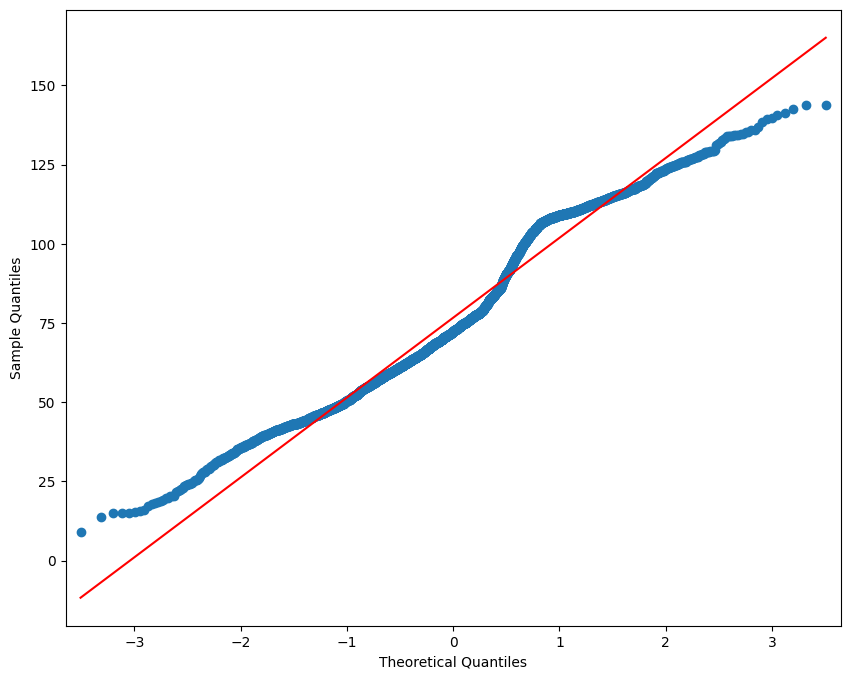

In [ ]:
# Daily
qqplot(df_crude['wti'], line='s')
qqplot(df_crude['brent'], line='s')
plt.show()

### Weekly

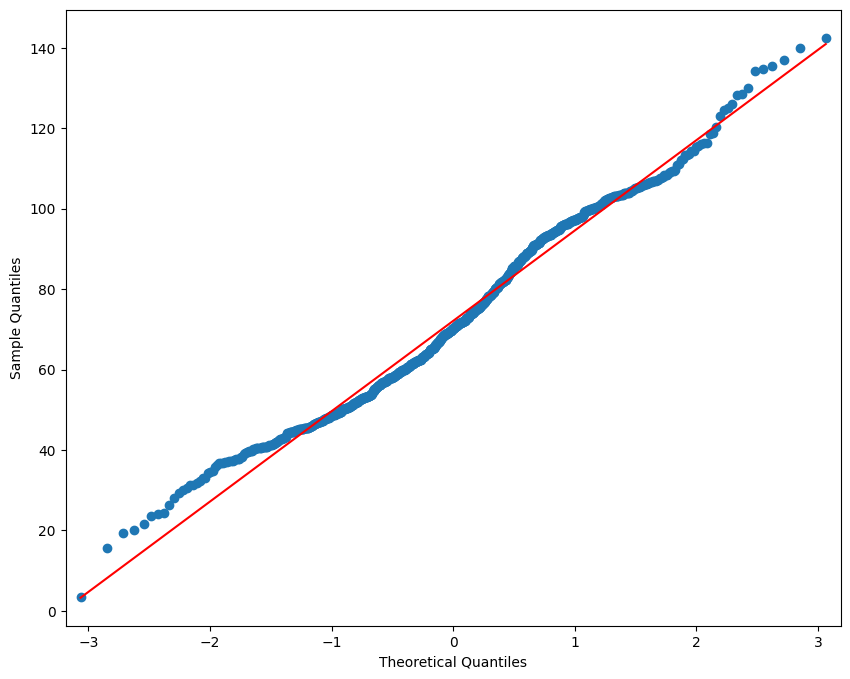

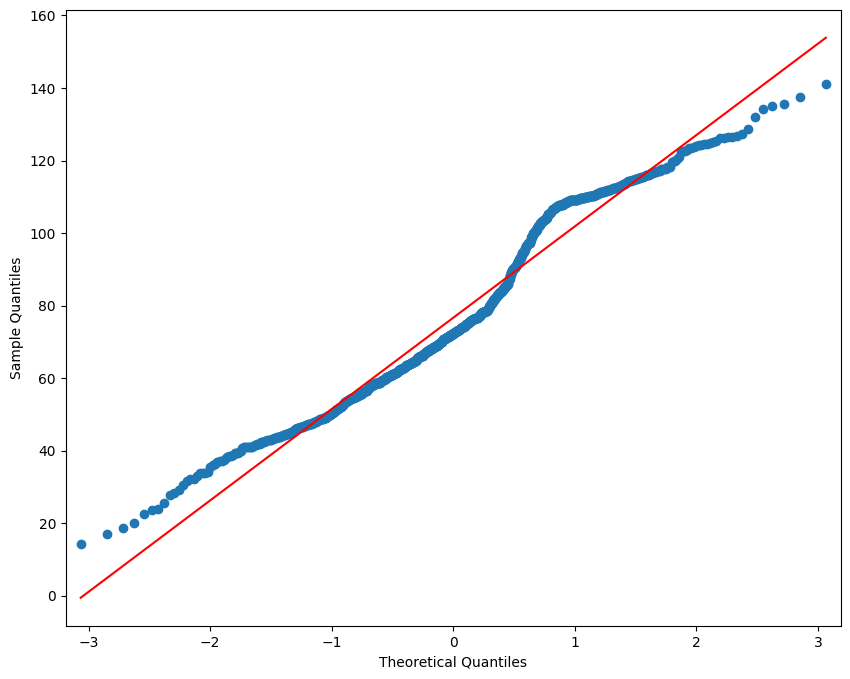

In [ ]:
# Weekly
qqplot(df_crude_weekly['wti'], line='s')
qqplot(df_crude_weekly['brent'], line='s')
plt.show()

## 5. Check Stationary

### Plot ACF and PACF

#### Daily

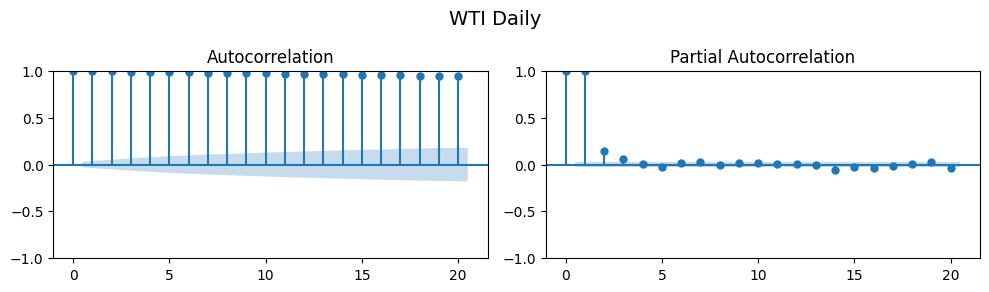

In [ ]:
# WTI Daily
fig = plt.figure(figsize=(10,5))
plt.suptitle('WTI Daily', fontsize=14)
ax1 = fig.add_subplot(221)
plot_acf(df_crude.wti, lags=20, ax=ax1)

ax2 = fig.add_subplot(222)
plot_pacf(df_crude.wti, lags=20, ax=ax2)

fig.tight_layout()
plt.show()

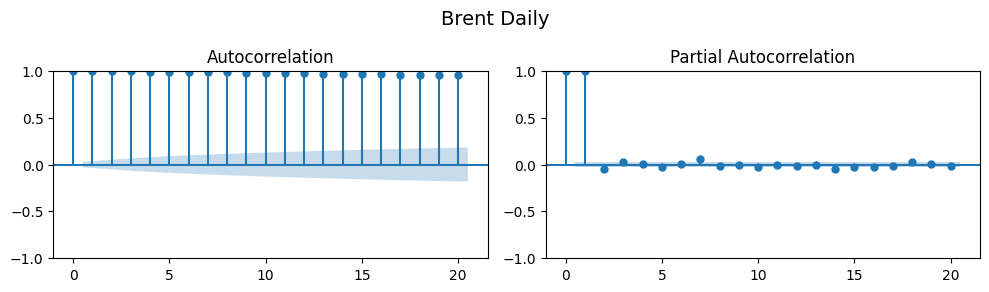

In [ ]:
# Brent Daily
fig = plt.figure(figsize=(10,5))
plt.suptitle('Brent Daily', fontsize=14)
ax1 = fig.add_subplot(221)
plot_acf(df_crude.brent, lags=20, ax=ax1)

ax2 = fig.add_subplot(222)
plot_pacf(df_crude.brent, lags=20, ax=ax2)

fig.tight_layout()
plt.show()

#### Weekly

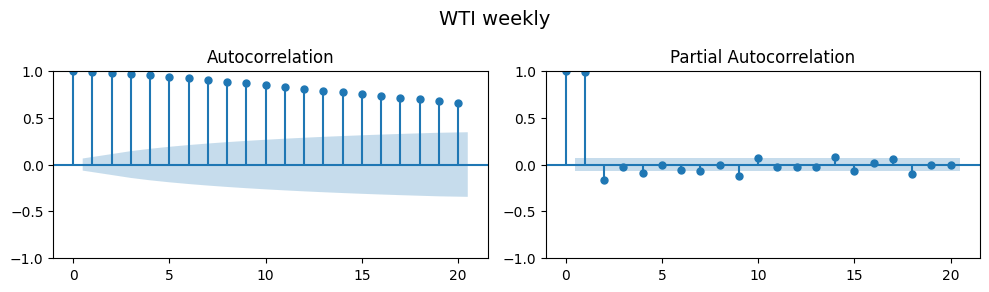

In [ ]:
# WTI Weekly
fig = plt.figure(figsize=(10,5))
plt.suptitle('WTI weekly', fontsize=14)
ax1 = fig.add_subplot(221)
plot_acf(df_crude_weekly.wti, lags=20, ax=ax1)

ax2 = fig.add_subplot(222)
plot_pacf(df_crude_weekly.wti, lags=20, ax=ax2)

fig.tight_layout()
plt.show()

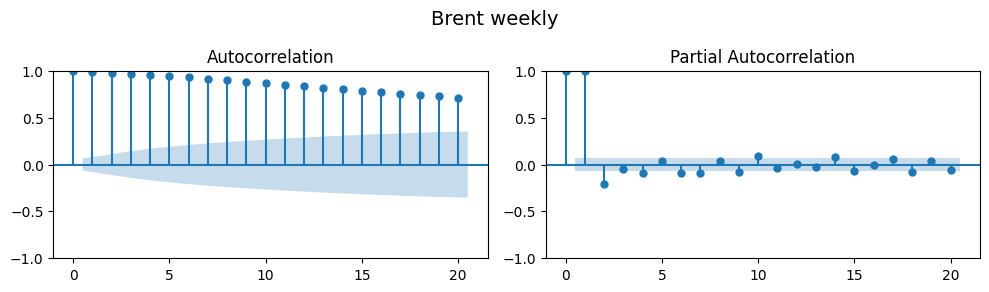

In [ ]:
# Brent Weekly
fig = plt.figure(figsize=(10,5))
plt.suptitle('Brent weekly', fontsize=14)
ax1 = fig.add_subplot(221)
plot_acf(df_crude_weekly.brent, lags=20, ax=ax1)

ax2 = fig.add_subplot(222)
plot_pacf(df_crude_weekly.brent, lags=20, ax=ax2)

fig.tight_layout()
plt.show()

### Compute Dickey-Fuller Test

In [ ]:
def adf_test(df):
    #Perform Dickey-Fuller test:
    print("Results of Dickey-Fuller Test\n================================================")
    dftest = adfuller(df, autolag="AIC")
    dfoutput = pd.Series(dftest[0:4], index = [
        "Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key, value in dftest[4].items():
        dfoutput["Criterical Value (%s)"%key] = value
    print(dfoutput)
    print("================================================")

    if dfoutput[0] < dfoutput[4]:
        print("The data is stationary. (Criterical Value 1%)")
    elif dfoutput[0] < dfoutput[5]:
        print("The data is stationary. (Criterical Value 5%)")
    elif dfoutput[0] < dfoutput[6]:
        print("The data is non-stationary, so do differencing!")
    else:
        print("The data is non-stationary, so do differencing!")

#### Daily

In [ ]:
adf_test(df_crude.wti)

Results of Dickey-Fuller Test
Test Statistic                   -2.914521
p-value                           0.043685
#Lags Used                       31.000000
Number of Observations Used    4344.000000
Criterical Value (1%)            -3.431856
Criterical Value (5%)            -2.862206
Criterical Value (10%)           -2.567124
dtype: float64
The data is stationary. (Criterical Value 5%)


Daily WTI crude oil price is a weak stationary because the p-value is 0.04.

In [ ]:
adf_test(df_crude.brent)

Results of Dickey-Fuller Test
Test Statistic                   -2.174754
p-value                           0.215536
#Lags Used                        6.000000
Number of Observations Used    4369.000000
Criterical Value (1%)            -3.431848
Criterical Value (5%)            -2.862202
Criterical Value (10%)           -2.567122
dtype: float64
The data is non-stationary, so do differencing!


#### Weekly

In [ ]:
adf_test(df_crude_weekly.wti)

Results of Dickey-Fuller Test
Test Statistic                  -3.165244
p-value                          0.022087
#Lags Used                      17.000000
Number of Observations Used    898.000000
Criterical Value (1%)           -3.437653
Criterical Value (5%)           -2.864764
Criterical Value (10%)          -2.568487
dtype: float64
The data is stationary. (Criterical Value 5%)


Weekly WTI crude oil price is a weak stationary because the p-value is 0.02.

In [ ]:
adf_test(df_crude_weekly.brent)

Results of Dickey-Fuller Test
Test Statistic                  -2.761137
p-value                          0.064043
#Lags Used                       9.000000
Number of Observations Used    906.000000
Criterical Value (1%)           -3.437588
Criterical Value (5%)           -2.864735
Criterical Value (10%)          -2.568471
dtype: float64
The data is non-stationary, so do differencing!


Overall, WTI and Brent prices are not the normal distribution. Also,
they are Non-Stationary or Weak Stationary, regardless of daily or weekly prices, so we should do first difference.

# Split the Data


In [ ]:
# Select dataset range
def dfrange(df, start=None, end=None, contractDays=10):
  df_reduced = df[start: end]
  df_pre, df_curr = df_reduced[0:-contractDays], df_reduced[-contractDays:]
  return df_reduced, df_pre, df_curr

## Daily Data

In [ ]:
# split into train and test sets
df_reduced, df_train, df_test = dfrange(df_crude, start='2016-01', end=None, contractDays=85) #training: 2016-2022; test:2023
print(df_reduced.shape, df_train.shape, df_test.shape)

(1813, 3) (1728, 3) (85, 3)


In [ ]:
print('Training dataset: {} trading days'.format(df_train.shape[0]))
print('Test dataset: {} trading days'.format(df_test.shape[0]))

Training dataset: 1728 trading days
Test dataset: 85 trading days


In [ ]:
df_train_wti = df_train[['wti']]
df_test_wti = df_test[['wti']]

df_train_brent = df_train[['brent']]
df_test_brent = df_test[['brent']]

## Weekly Data

In [ ]:
# split into train and test sets
df_weeklyreduced, df_weeklytrain, df_weeklytest = dfrange(df_crude_weekly, start='201601', end=None, contractDays=19) #training: 2016-2022; test:2023
print(df_weeklyreduced.shape, df_weeklytrain.shape, df_weeklytest.shape)

(331, 3) (312, 3) (19, 3)


In [ ]:
print('Training dataset: {} trading weeks'.format(df_weeklytrain.shape[0]))
print('Test dataset: {} trading weeks'.format(df_weeklytest.shape[0]))

Training dataset: 312 trading weeks
Test dataset: 19 trading weeks


In [ ]:
df_weeklytrain_wti = df_weeklytrain[['wti']]
df_weeklytest_wti = df_weeklytest[['wti']]

df_weeklytrain_brent = df_weeklytrain[['brent']]
df_weeklytest_brent = df_weeklytest[['brent']]

# Build prediction models



In [ ]:
def Arima_model(df_train):
  p = d = q = range(0, 3)
  pdq = list(itertools.product(p, d, q))
  bs = {}
  for param in pdq:
    try:
      res = ARIMA(df_train, order=param).fit()
      bs[param] = res.aic
      #print('ARIMA{} - AIC:{:.4f}'.format(param, res.aic))
    except:
      continue
  best_pdq = min(bs, key=bs.get) # select the minimum AIC parameter set
  print('ARIMA(p,d,q) =', best_pdq ,'is the best.')

  # Build the model with the best parameters
  fitted = ARIMA(df_train, order=best_pdq).fit()

  return fitted

In [ ]:
def SimpleExpSmoothing_model(df_train):
  fit1 = SimpleExpSmoothing(df_train, initialization_method="heuristic").fit(
    smoothing_level=0.2, optimized=False)
  fit2 = SimpleExpSmoothing(df_train, initialization_method="heuristic").fit(
    smoothing_level=0.6, optimized=False)
  fit3 = SimpleExpSmoothing(df_train, initialization_method="estimated").fit()

  bs = {fit1:fit1.aic, fit2:fit2.aic, fit3:fit3.aic}
  fitted = min(bs, key=bs.get) # select the minimum AIC parameter set
  return fitted

In [ ]:
def ExpSmoothing_model(df_train):
  fitted = ExponentialSmoothing(df_train,
                             seasonal_periods=2,
                             trend='add',
                             seasonal='mul',
                             damped_trend=True,
                             use_boxcox=True,
                             initialization_method='estimated').fit()
  return fitted

In [ ]:
def ARIMAX_model(df_train, exog_train):
  resDiff = sm.tsa.arma_order_select_ic(df_train, max_ar=7, max_ma=7, ic='aic', trend='c')
  print('ARMA(p,q) =',resDiff['aic_min_order'],'is the best.')
  p = resDiff['aic_min_order'][0]
  q = resDiff['aic_min_order'][1]
  fitted = sm.tsa.statespace.SARIMAX(df_train, order=(p,0,q),
                            seasonal_order=(0,0,0,0), # without seasonal
                            exog = exog_train,
                            enforce_stationarity=False,
                            enforce_invertibility=False).fit()
  return fitted

In [ ]:
def check_residuals(fit):
  res = fit.resid
  fig = plt.figure(figsize=(10,5))
  ax1 = fig.add_subplot(221)
  plot_acf(res, lags=20, ax=ax1)
  ax2 = fig.add_subplot(222)
  plot_pacf(res, lags=20, ax=ax2)
  fig.tight_layout()
  plt.show()

In [ ]:
def forecast(df_train, df_test, exog_test, dname='WTI', fit_arima=None, fit_ses=None, fit_es=None, fit_arimax=None):

  print('[{} Oil Price Forecast]'.format(dname))

  # Forecast
  n = len(df_test)
  fcast_arima = fit_arima.forecast(n)
  fcast_ses = fit_ses.forecast(n)
  fcast_es = fit_es.forecast(n)
  fcast_arimax = fit_arimax.forecast(n, exog = exog_test)

  # Create forecast table
  d1 = fcast_arima.to_frame()
  d1.rename(columns={'predicted_mean':'pred_Arima'}, inplace=True)
  d1.set_index(df_test.index, inplace=True)
  d2 = fcast_ses.to_frame()
  d2.set_index(df_test.index, inplace=True)
  d3 = fcast_es.to_frame()
  d3.set_index(df_test.index, inplace=True)
  d4 = fcast_arimax.to_frame()
  d4.set_index(df_test.index, inplace=True)

  df_fcast = pd.merge(pd.merge(pd.merge(d1, d2, left_index=True, right_index=True),
                               d3, left_index=True, right_index=True),
                      d4, left_index=True, right_index=True)
  df_fcast = df_fcast.rename(columns={'0_x':'pred_SimpleExpSmoothing',
                                      '0_y':'pred_ExpSmoothing',
                                      'predicted_mean':'pred_Arimax'})

  # Evaluate
  ## Arima
  rmse = np.sqrt(mean_squared_error(df_test, fcast_arima))
  mae = mean_absolute_error(df_test, fcast_arima)
  mape = mean_absolute_percentage_error(df_test, fcast_arima)
  print('Arima Model: rmse:{:.4f}; mae:{:.4f}; mape:{:.4f}'.format(rmse, mae, mape))

  ## SimpleExpSmoothing
  rmse = np.sqrt(mean_squared_error(df_test, fcast_ses))
  mae = mean_absolute_error(df_test, fcast_ses)
  mape = mean_absolute_percentage_error(df_test, fcast_ses)
  print('SimpleExpSmoothing Model: rmse:{:.4f}; mae:{:.4f}; mape:{:.4f}'.format(rmse, mae, mape))

  ## ExpSmoothing
  rmse = np.sqrt(mean_squared_error(df_test, fcast_es))
  mae = mean_absolute_error(df_test, fcast_es)
  mape = mean_absolute_percentage_error(df_test, fcast_es)
  print('ExpSmoothing Model: rmse:{:.4f}; mae:{:.4f}; mape:{:.4f}'.format(rmse, mae, mape))

  ## Arimax
  rmse = np.sqrt(mean_squared_error(df_test, fcast_arimax))
  mae = mean_absolute_error(df_test, fcast_arimax)
  mape = mean_absolute_percentage_error(df_test, fcast_arimax)
  print('Arimax Model: rmse:{:.4f}; mae:{:.4f}; mape:{:.4f}'.format(rmse, mae, mape))
  print()

  # Plot
  plt.figure(figsize=(20, 8))
  plt.plot(df_train, color="gray", label='train')
  plt.plot(df_test, color="black", label='test')
  plt.plot(df_test.index, fcast_arima, label='pred_Arima')
  plt.plot(df_test.index, fcast_ses, label='pred_SimpleExpSmoothing')
  plt.plot(df_test.index, fcast_es, label='pred_ExpSmoothing')
  plt.plot(df_test.index, fcast_arimax, label='pred_Arimax')
  plt.title('{} Forecast vs Actuals'.format(dname))
  plt.xlabel('Date')
  plt.ylabel('Price')
  plt.grid(linestyle='--')
  #plt.xticks(rotation=45)
  plt.legend(loc='best')
  plt.show()
  print()

  return df_fcast

In [ ]:
def forecast_weekly(df_train, df_test, exog_test, dname='WTI', fit_arima=None, fit_ses=None, fit_es=None, fit_arimax=None):

  print('[{} Oil Price Forecast]'.format(dname))

  # Forecast
  n = len(df_test)
  fcast_arima = fit_arima.forecast(n)
  fcast_ses = fit_ses.forecast(n)
  fcast_es = fit_es.forecast(n)
  fcast_arimax = fit_arimax.forecast(n, exog = exog_test)

  # Create forecast table
  d1 = fcast_arima.to_frame()
  d1.rename(columns={'predicted_mean':'pred_Arima'}, inplace=True)
  d1.set_index(df_test.index, inplace=True)
  d2 = fcast_ses.to_frame()
  d2.set_index(df_test.index, inplace=True)
  d3 = fcast_es.to_frame()
  d3.set_index(df_test.index, inplace=True)
  d4 = fcast_arimax.to_frame()
  d4.set_index(df_test.index, inplace=True)

  df_fcast = pd.merge(pd.merge(pd.merge(d1, d2, left_index=True, right_index=True),
                               d3, left_index=True, right_index=True),
                      d4, left_index=True, right_index=True)
  df_fcast = df_fcast.rename(columns={'0_x':'pred_SimpleExpSmoothing',
                                      '0_y':'pred_ExpSmoothing',
                                      'predicted_mean':'pred_Arimax'})

  # Evaluate
  ## Arima
  rmse = np.sqrt(mean_squared_error(df_test, fcast_arima))
  mae = mean_absolute_error(df_test, fcast_arima)
  mape = mean_absolute_percentage_error(df_test, fcast_arima)
  print('Arima Model: rmse:{:.4f}; mae:{:.4f}; mape:{:.4f}'.format(rmse, mae, mape))

  ## SimpleExpSmoothing
  rmse = np.sqrt(mean_squared_error(df_test, fcast_ses))
  mae = mean_absolute_error(df_test, fcast_ses)
  mape = mean_absolute_percentage_error(df_test, fcast_ses)
  print('SimpleExpSmoothing Model: rmse:{:.4f}; mae:{:.4f}; mape:{:.4f}'.format(rmse, mae, mape))

  ## ExpSmoothing
  rmse = np.sqrt(mean_squared_error(df_test, fcast_es))
  mae = mean_absolute_error(df_test, fcast_es)
  mape = mean_absolute_percentage_error(df_test, fcast_es)
  print('ExpSmoothing Model: rmse:{:.4f}; mae:{:.4f}; mape:{:.4f}'.format(rmse, mae, mape))

  ## Arimax
  rmse = np.sqrt(mean_squared_error(df_test, fcast_arimax))
  mae = mean_absolute_error(df_test, fcast_arimax)
  mape = mean_absolute_percentage_error(df_test, fcast_arimax)
  print('Arimax Model: rmse:{:.4f}; mae:{:.4f}; mape:{:.4f}'.format(rmse, mae, mape))
  print()

  # Plot
  plt.figure(figsize=(20, 8))
  plt.plot(df_train, color="gray", label='train')
  plt.plot(df_test, color="black", label='test')
  plt.plot(df_test.index, fcast_arima, label='pred_Arima')
  plt.plot(df_test.index, fcast_ses, label='pred_SimpleExpSmoothing')
  plt.plot(df_test.index, fcast_es, label='pred_ExpSmoothing')
  plt.plot(df_test.index, fcast_arimax, label='pred_Arimax')
  plt.title('{} Forecast vs Actuals'.format(dname))
  plt.xlabel('Date')
  plt.ylabel('Price')
  plt.grid(linestyle='--')
  plt.xticks(())
  #plt.xticks(rotation=45)
  plt.legend(loc='best')
  plt.show()
  print()

  return df_fcast

## WTI - Daily

In [ ]:
# ExpSmoothing model can only use positive data
# Convert the negative value to the mean value
df_train_modwti = df_train_wti
df_train_modwti.replace(-36.98, df_train_modwti.mean()[0], inplace=True)

In [ ]:
random.seed(0)
fit1 = Arima_model(df_train_wti)
fit2 = SimpleExpSmoothing_model(df_train_wti)
fit3 = ExpSmoothing_model(df_train_modwti)
fit4 = ARIMAX_model(df_train_wti, df_train_brent)

ARIMA(p,d,q) = (0, 1, 1) is the best.
ARMA(p,q) = (7, 5) is the best.


WTI Daily data with Arima Model


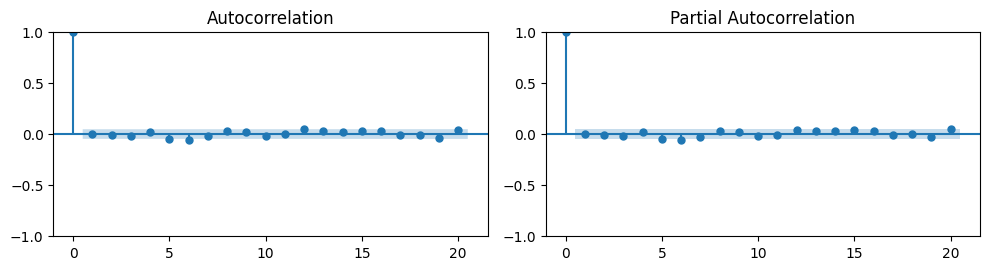

In [ ]:
print('WTI Daily data with Arima Model')
check_residuals(fit1)

WTI Daily data with SimpleExpSmoothing Model


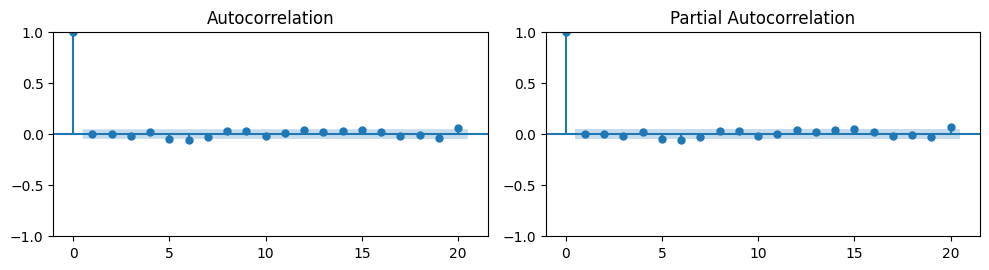

In [ ]:
print('WTI Daily data with SimpleExpSmoothing Model')
check_residuals(fit2)

WTI Daily data with ExpSmoothing Model


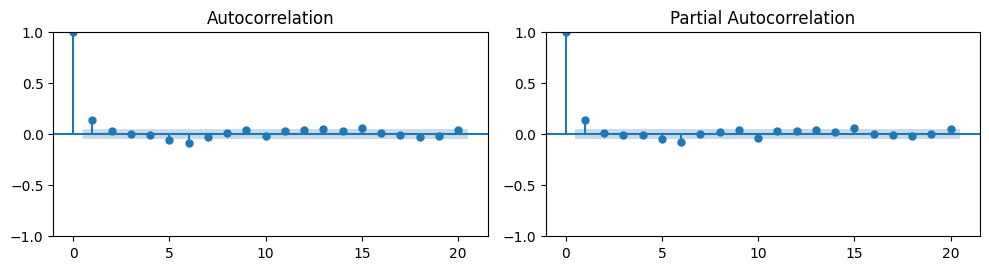

In [ ]:
print('WTI Daily data with ExpSmoothing Model')
check_residuals(fit3)

WTI Daily data with Arimax Model


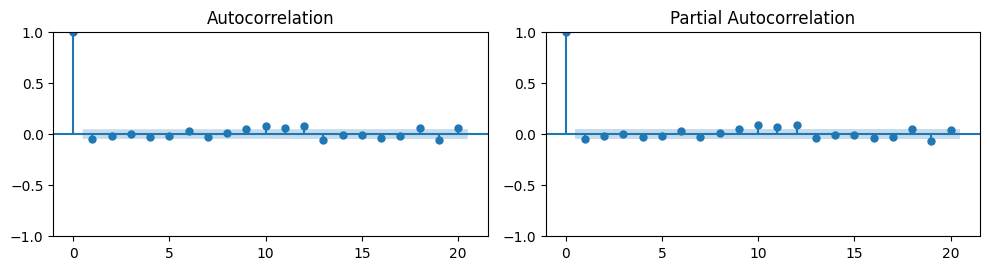

In [ ]:
print('WTI Daily data with Arimax Model')
check_residuals(fit4)

Daily
[WTI Oil Price Forecast]
Arima Model: rmse:5.1787; mae:3.9002; mape:0.0535
SimpleExpSmoothing Model: rmse:5.1785; mae:3.9001; mape:0.0535
ExpSmoothing Model: rmse:5.2265; mae:3.9334; mape:0.0540
Arimax Model: rmse:1.3317; mae:1.1240; mape:0.0150



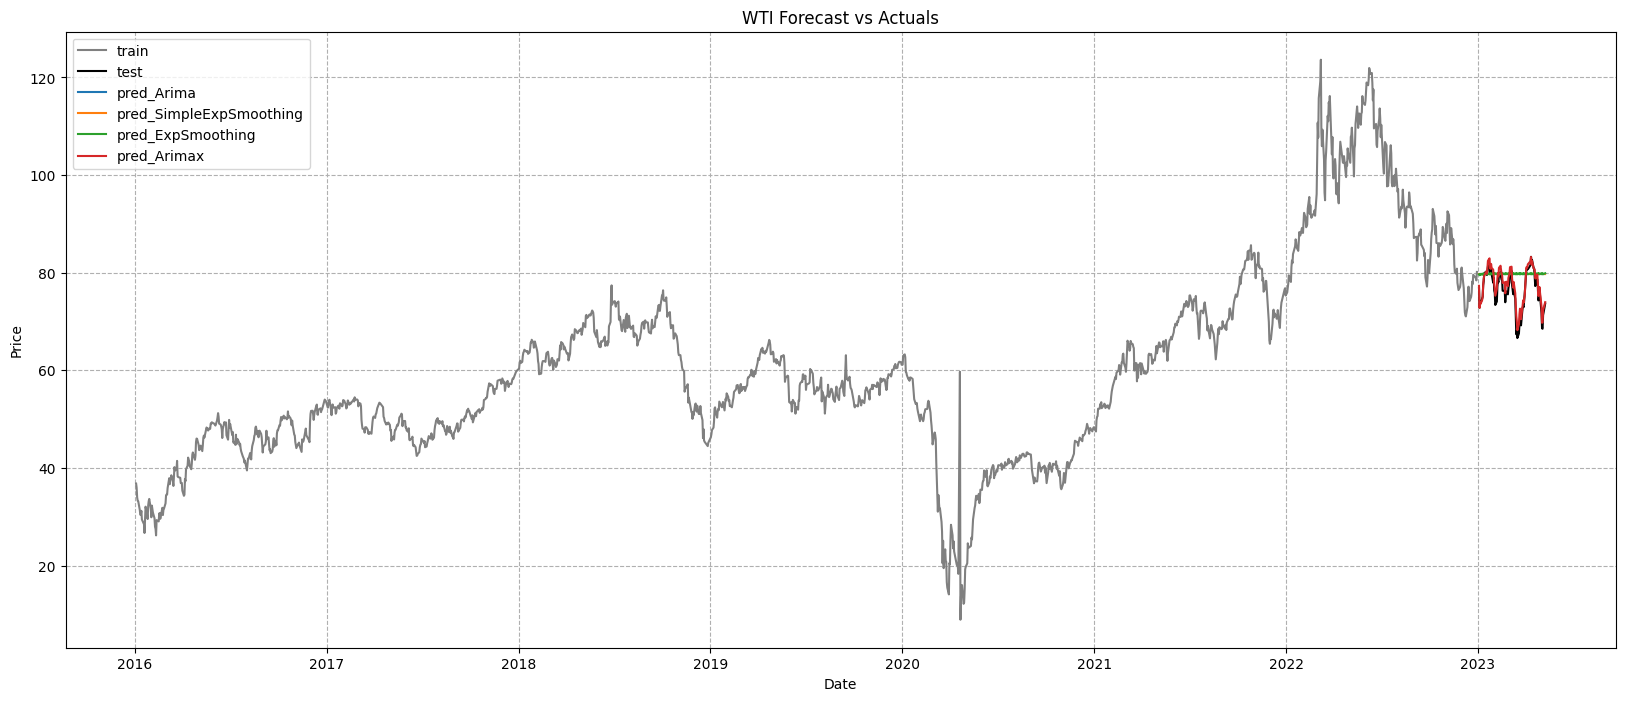

In [ ]:
print('Daily')
df_fcast_wti = forecast(df_train_wti, df_test_wti, df_test_brent, dname='WTI',
                        fit_arima=fit1, fit_ses=fit2, fit_es=fit3, fit_arimax=fit4)

## WTI - Weekly

In [ ]:
random.seed(0)
fit1 = Arima_model(df_weeklytrain_wti)
fit2 = SimpleExpSmoothing_model(df_weeklytrain_wti)
fit3 = ExpSmoothing_model(df_weeklytrain_wti)
fit4 = ARIMAX_model(df_weeklytrain_wti, df_weeklytrain_brent)

ARIMA(p,d,q) = (0, 1, 0) is the best.
ARMA(p,q) = (4, 3) is the best.


Weekly
[WTI Oil Price Forecast]
Arima Model: rmse:4.6918; mae:3.6358; mape:0.0496
SimpleExpSmoothing Model: rmse:4.6918; mae:3.6358; mape:0.0496
ExpSmoothing Model: rmse:4.5315; mae:3.4892; mape:0.0476
Arimax Model: rmse:0.9053; mae:0.7676; mape:0.0102



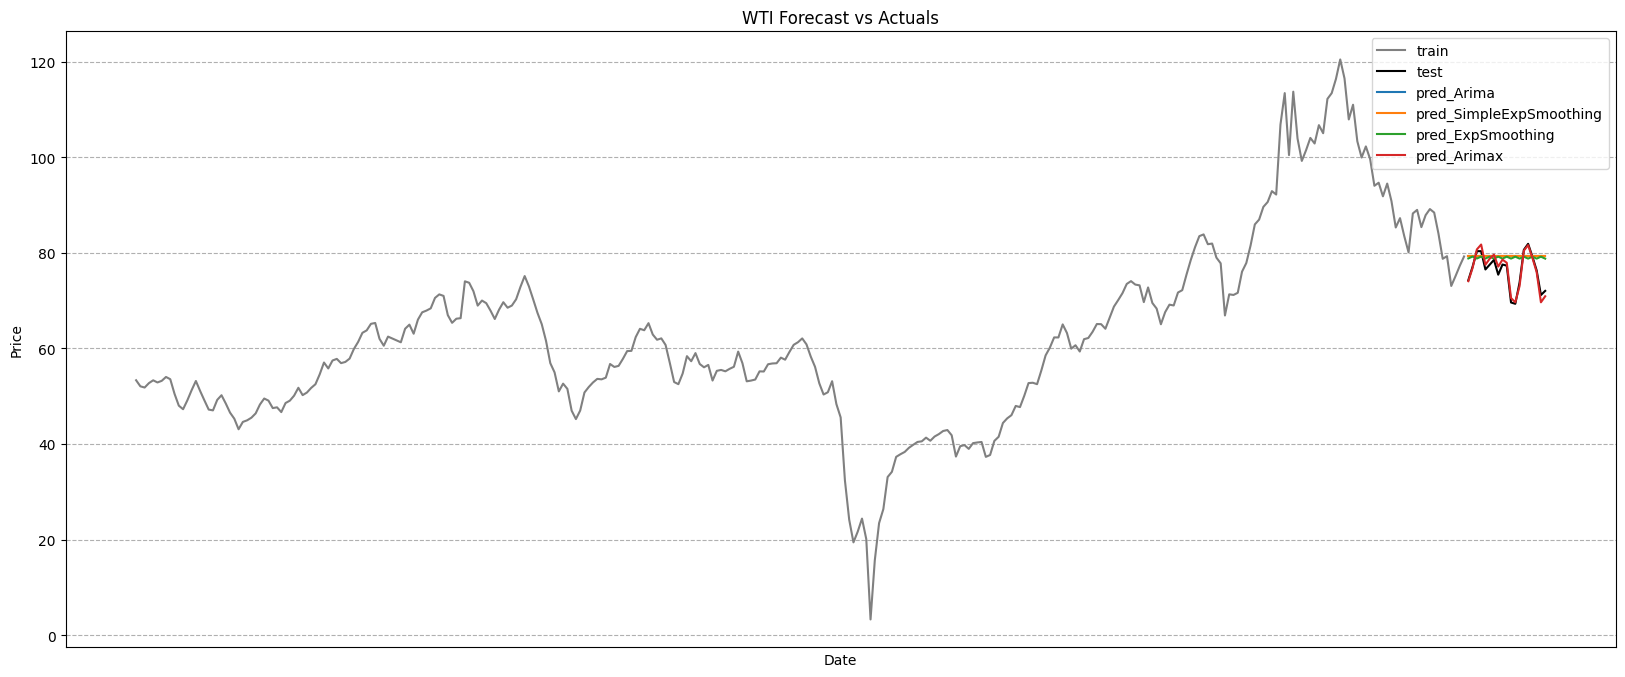

In [ ]:
print('Weekly')
df_weeklyfcast_wti = forecast_weekly(df_weeklytrain_wti, df_weeklytest_wti, df_weeklytest_brent, dname='WTI',
                              fit_arima=fit1, fit_ses=fit2, fit_es=fit3, fit_arimax=fit4)

## Brent - Daily

In [ ]:
random.seed(10)
fit11 = Arima_model(df_train_brent)
fit12 = SimpleExpSmoothing_model(df_train_brent)
fit13 = ExpSmoothing_model(df_train_brent)
fit14 = ARIMAX_model(df_train_brent, df_train_wti)

ARIMA(p,d,q) = (2, 1, 2) is the best.
ARMA(p,q) = (7, 7) is the best.


Daily
[Brent Oil Price Forecast]
Arima Model: rmse:4.4271; mae:3.5029; mape:0.0445
SimpleExpSmoothing Model: rmse:4.4623; mae:3.4960; mape:0.0444
ExpSmoothing Model: rmse:4.4761; mae:3.4983; mape:0.0445
Arimax Model: rmse:2.3336; mae:2.0825; mape:0.0254



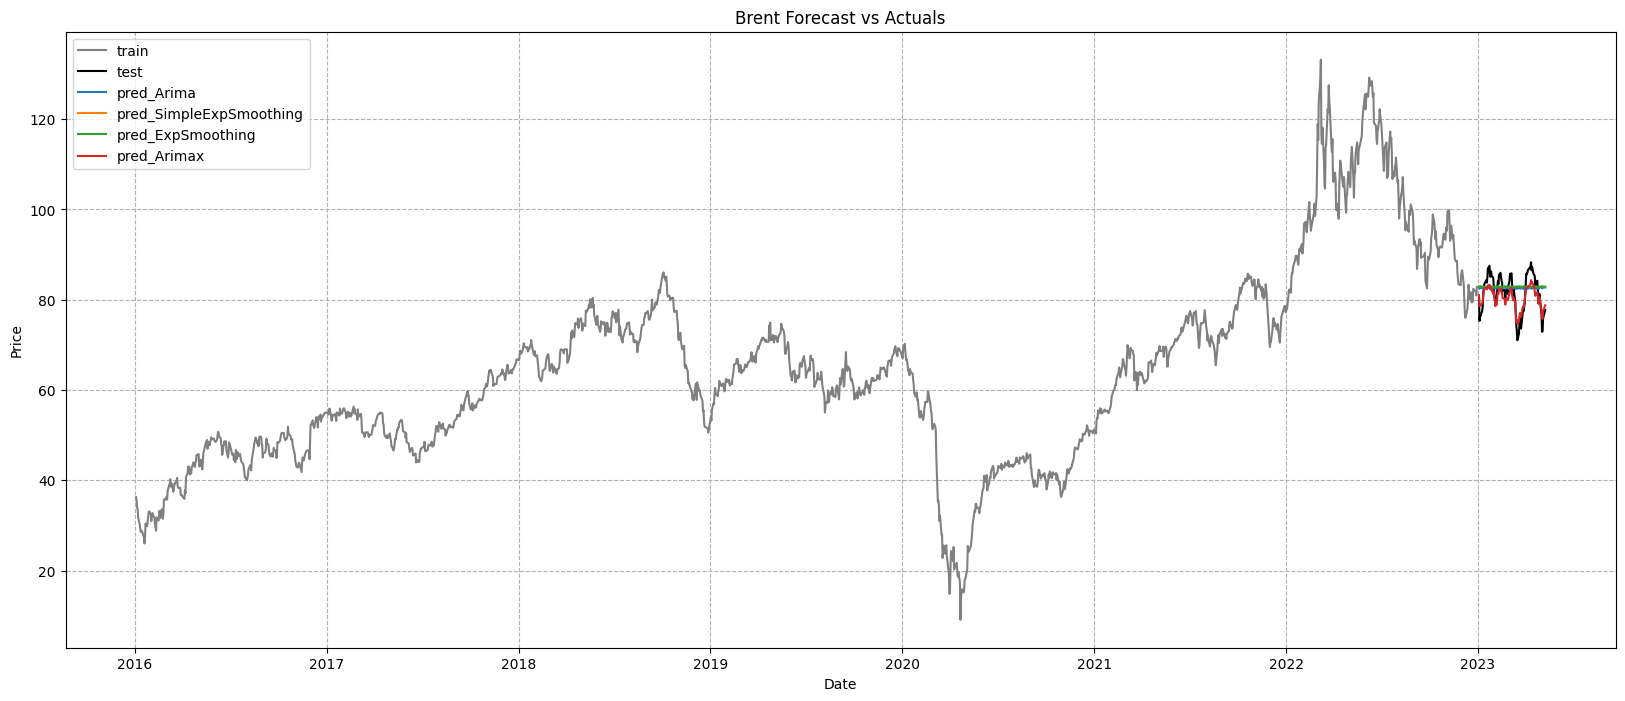

In [ ]:
print('Daily')
df_fcast_brent = forecast(df_train_brent, df_test_brent, df_test_wti, dname='Brent',
                          fit_arima=fit11, fit_ses=fit12, fit_es=fit13, fit_arimax=fit14)

## Brent - Weekly

In [ ]:
random.seed(10)
fit11 = Arima_model(df_weeklytrain_brent)
fit12 = SimpleExpSmoothing_model(df_weeklytrain_brent)
fit13 = ExpSmoothing_model(df_weeklytrain_brent)
fit14 = ARIMAX_model(df_weeklytrain_brent, df_weeklytrain_wti)

ARIMA(p,d,q) = (1, 1, 2) is the best.
ARMA(p,q) = (3, 5) is the best.


Weekly
[Brent Oil Price Forecast]
Arima Model: rmse:4.1995; mae:3.3421; mape:0.0424
SimpleExpSmoothing Model: rmse:4.0971; mae:3.3426; mape:0.0421
ExpSmoothing Model: rmse:4.1296; mae:3.3581; mape:0.0423
Arimax Model: rmse:0.8824; mae:0.7951; mape:0.0098



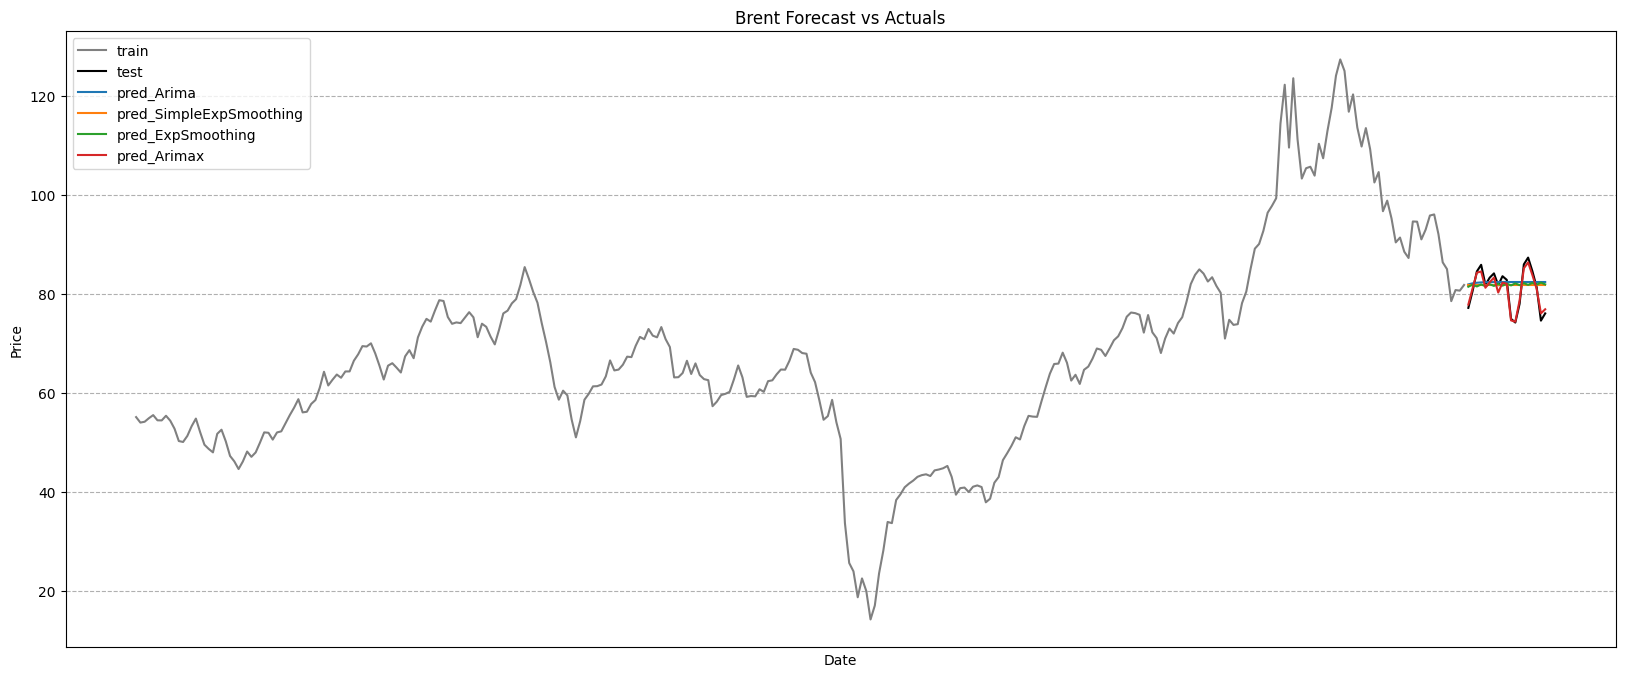

In [ ]:
print('Weekly')
df_weeklyfcast_brent = forecast_weekly(df_weeklytrain_brent, df_weeklytest_brent, df_weeklytest_wti, dname='Brent',
                                       fit_arima=fit11, fit_ses=fit12, fit_es=fit13, fit_arimax=fit14)

# Build the index-based pricing formula

We want to investigate models for gas prices. For example, suppose that gasoline prices (or its primary component before blending, RBOB) are modeled by:

$P_{\textrm{gas}} = \textrm{PreviousCost} \cdot ( 1 + w_{\textrm{WTI}}  \Delta P_{\textrm{WTI}} + w_{\textrm{Brent}} \Delta P_{\textrm{Brent}}) \cdot (1 + m)$

where $\Sigma_{i} w_{i} = 1$, $\Delta P_{i}$ are relative fractional differences, and $m$ is the margin percentage.

- Choose a margin percentage and find an optimal value of the weights that minimizes the difference between the model and the desired margin percentage.
- What is the standard deviation about the average value?
- An alternate model might depend upon the absolute differences in prices:

$P_{\textrm{gas}} = (\textrm{PreviousCost}  + w_{\textrm{WTI}}  \Delta P_{\textrm{WTI}} + w_{\textrm{Brent}} \Delta P_{\textrm{Brent}}) \cdot (1 + m)$

where the $\Delta P$ values are now absolute rather than relative values.

PreviousCost(Weighted Crude) = (%wgt_WTI * WTI + %wgt_Brent * Brent) / Callons per barrel

where %wgt_WTI + %wgt_Brent = 1; Callons per barrel = 42


In [ ]:
# Compute Previous Cost
def previousCost(df_pre, freq=None, wgt_wti=None, wgt_brent=None):
  pc_wti = df_pre.wti.tail(freq).mean()                     # average previous prices
  pc_brent = df_pre.brent.tail(freq).mean()
  previous_cost = (wgt_wti*pc_wti + wgt_brent*pc_brent)/42  # Callons per barrel = 42
  return previous_cost

# Compute Margin
def margins(df_pre, freq=None, previous_cost=None):
  pc_rbob = df_pre.rbob.tail(freq).mean()
  markup = (pc_rbob/previous_cost)-1

  #pct_markup = pc_rbob/df_pre.rbob.mean()
  #pct_markup = pc_rbob/df_pre.rbob.tail(14).mean()
  pct_markup = 1
  margin = markup*pct_markup
  return margin

# Compute Weighted Crude
def weightedCrude(df_curr, wgt_wti=None, wgt_brent=None):
  weighted_crude = (wgt_wti*df_curr.wti + wgt_brent*df_curr.brent)/42  # Callons per barrel = 42
  return weighted_crude

In [ ]:
# Compute Contract Price
def contractPrice(df_pre, df_curr, freq=None, n=10):
  lst = []
  dw = {}
  #db = {}
  wlst = np.linspace(1.0, 0.0, n)
  for i in range(n):
    wgt_wti = wlst[i]
    wgt_brent = 1 - wgt_wti

    previous_cost= previousCost(df_pre, freq=freq, wgt_wti=wgt_wti, wgt_brent=wgt_brent)
    margin = margins(df_pre, freq=freq, previous_cost=previous_cost)

    # calcuate the idnex
    idx_wti = df_curr.wti.pct_change(1) # will miss first row
    idx_wti[0] = (df_curr.wti.iloc[0] - df_pre.wti.iloc[-1]) / df_pre.wti.iloc[-1] # update the first row
    idx_brent = df_curr.brent.pct_change(1)
    idx_brent[0] = (df_curr.brent.iloc[0] - df_pre.brent.iloc[-1]) / df_pre.brent.iloc[-1]

    contract_price = previous_cost * (1 + wgt_wti*idx_wti + wgt_brent*idx_brent) * (1 + margin)
    weighted_crude = weightedCrude(df_curr, wgt_wti=wgt_wti, wgt_brent=wgt_brent)

    # calculate the errors
    error = abs(df_curr.rbob - contract_price)
    total_error = error.sum()
    avg_error = error.mean()
    dw[wgt_wti] = avg_error
    #db[wgt_brent] = avg_error
    lst.append({'wgt_wti':wgt_wti, 'wgt_brent':wgt_brent,
                'contract_price': contract_price, 'weighted_crude':weighted_crude,
                'total_error':total_error, 'avg_error':avg_error})
  print()
  # Plot Weight Graph
  plt.figure(figsize=(5,3))
  plt.plot(dw.keys(), dw.values(), color='green', label='WTI Weight')
  #plt.plot(db.keys(), db.values(), color='green', label='Brent Weight')
  plt.xlabel('Weights')
  plt.ylabel('Mean Absolute Error from RBOB Price')
  plt.title('')
  plt.grid(linestyle='--')
  plt.legend(loc='best')
  plt.show()
  print()

  #Select the best weights
  bs = {}
  for i in range(len(lst)):
    #print('WTI Weight: {:.4f}, Brent Weight: {:.4f}, Total Absolute Error: {:.4f} price, Mean Absolute Error: {:.4f} price'
    #.format(lst[i].get('wgt_wti'), lst[i].get('wgt_brent'), lst[i].get('total_error'), lst[i].get('avg_error')))

    bs[i] = lst[i].get('total_error')

  j = min(bs, key=bs.get)
  print()
  print('[Best weights in {} day(s) mean previous cost]'.format(freq))
  print()
  print('WTI Weight: {:.4f}, Brent Weight: {:.4f}, Total Absolute Error: {:.4f} price, Mean Absolute Error: {:.4f} price'
    .format(lst[j].get('wgt_wti'), lst[j].get('wgt_brent'), lst[j].get('total_error'), lst[j].get('avg_error')))
  print()

  # Plot Contract Price
  plt.figure(figsize=(10,3))
  plt.plot(df_curr.index, lst[j].get('contract_price'), label='Contract Price')
  plt.plot(df_curr.index, df_curr.rbob, label='RBOB Price')
  plt.plot(df_curr.index, lst[j].get('weighted_crude'), color='gray', label='Weighted Cost')
  plt.xlabel('Date')
  plt.ylabel('RBOB Price')
  plt.title('Data vs. Index-Based Model')
  plt.grid(linestyle='--')
  plt.xticks(rotation= 45)
  plt.legend(loc='best')
  plt.show()

  #return margin

# Build contract prices with the best model

## Daily contract prices

*   WTI best model: Arimax Model
*   Brent best model: Arimax Model

In [ ]:
df_fcast_wti = df_fcast_wti[['pred_Arimax']]
df_fcast_brent = df_fcast_brent[['pred_Arimax']]
df_fcast = (
    pd.merge(pd.merge(df_fcast_wti, df_fcast_brent, left_index=True, right_index=True), df_test.rbob, left_index=True, right_index=True)
    .rename(columns={'pred_Arimax_x':'wti', 'pred_Arimax_y':'brent'})
)
df_fcast.head()

,wti,brent,rbob
date,,,
2023-01-03,77.316916,81.001867,2.361
2023-01-04,72.798790,78.614737,2.259
2023-01-05,74.014448,78.790873,2.267
2023-01-06,73.625117,78.742489,2.245
2023-01-09,74.395036,79.256281,2.293



*   Daily price
*   Select contract size: How long is the prediction?
*   Select frequence: How long is the previous cost?
*   Select weight interval: How many intervals of weight?







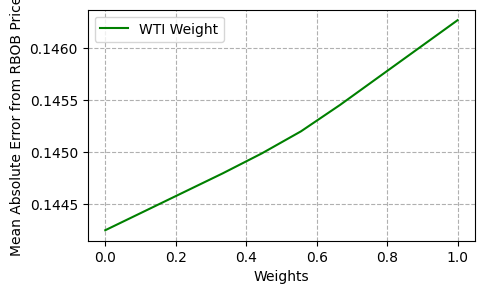



[Best weights in 1 day(s) mean previous cost]

WTI Weight: 0.0000, Brent Weight: 1.0000, Total Absolute Error: 12.2614 price, Mean Absolute Error: 0.1443 price



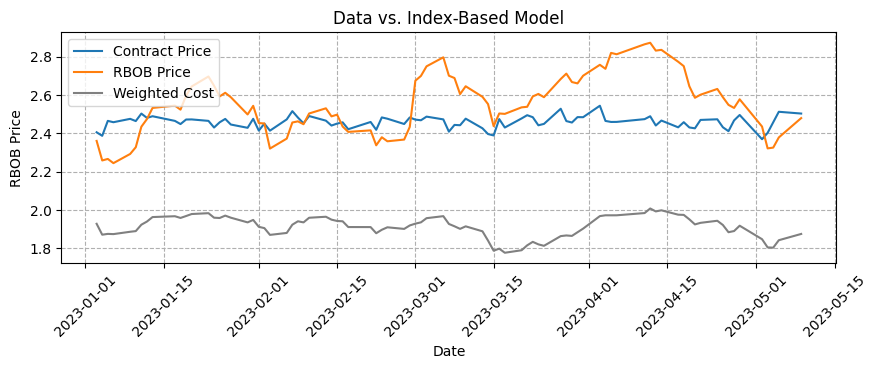

In [ ]:
days_previous_cost = 1
weight_interval = 10
contractPrice(df_train, df_fcast, freq=days_previous_cost, n=weight_interval)

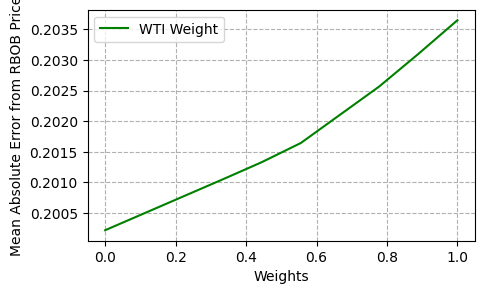



[Best weights in 5 day(s) mean previous cost]

WTI Weight: 0.0000, Brent Weight: 1.0000, Total Absolute Error: 17.0188 price, Mean Absolute Error: 0.2002 price



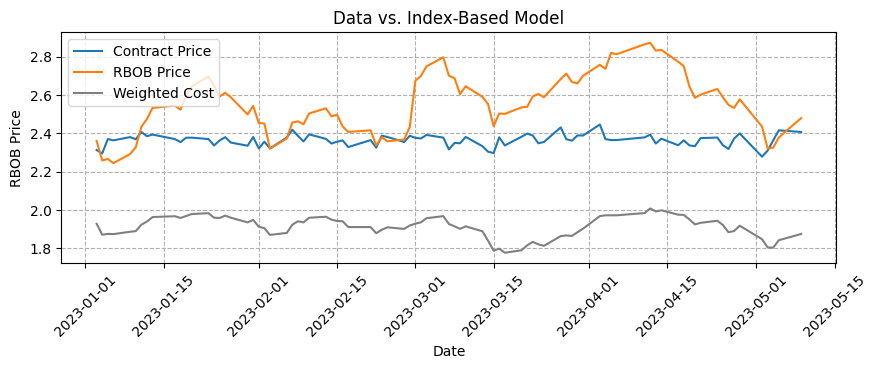

In [ ]:
days_previous_cost = 5
weight_interval = 10
contractPrice(df_train, df_fcast, freq=days_previous_cost, n=weight_interval)

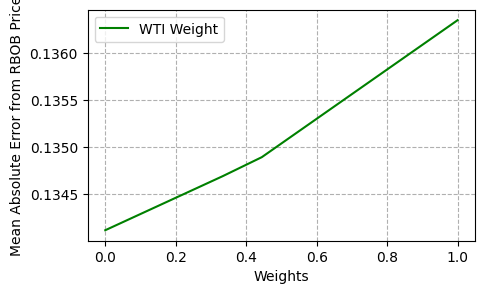



[Best weights in 85 day(s) mean previous cost]

WTI Weight: 0.0000, Brent Weight: 1.0000, Total Absolute Error: 11.3995 price, Mean Absolute Error: 0.1341 price



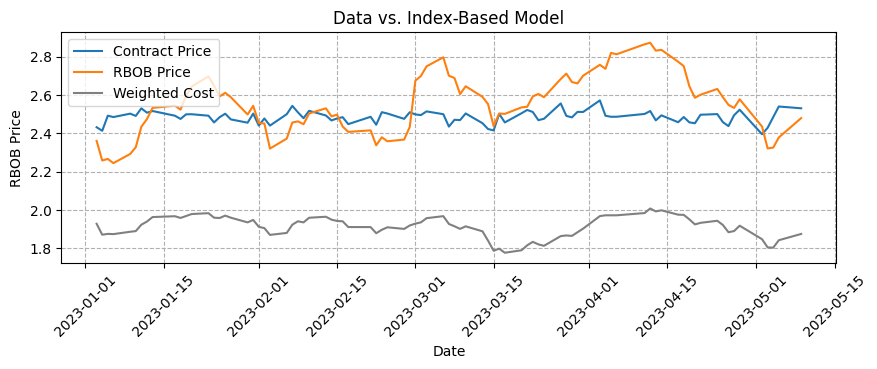

In [ ]:
days_previous_cost = 85
weight_interval = 10
contractPrice(df_train, df_fcast, freq=days_previous_cost, n=weight_interval)

## Weekly contract prices

*   WTI best model: Arimax Model
*   Brent best model: Arimax Model

In [ ]:
df_weeklyfcast_wti = df_weeklyfcast_wti[['pred_Arimax']]
df_weeklyfcast_brent = df_weeklyfcast_brent[['pred_Arimax']]
df_weeklyfcast = (
    pd.merge(pd.merge(df_weeklyfcast_wti, df_weeklyfcast_brent, left_index=True, right_index=True), df_weeklytest.rbob, left_index=True, right_index=True)
    .rename(columns={'pred_Arimax_x':'wti', 'pred_Arimax_y':'brent'})
)
df_weeklyfcast.head()

,wti,brent,rbob
week,,,
2023-01,74.058566,77.857703,2.28300
2023-02,76.844682,81.148056,2.41280
2023-03,80.700684,84.315745,2.57775
2023-04,81.724944,84.552068,2.62800
2023-05,77.491577,81.265463,2.45400


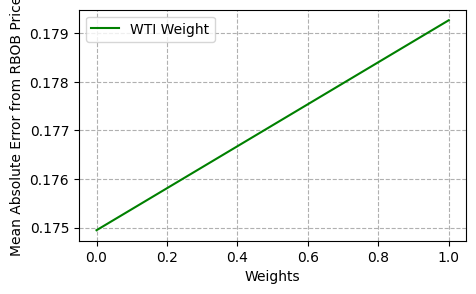



[Best weights in 1 day(s) mean previous cost]

WTI Weight: 0.0000, Brent Weight: 1.0000, Total Absolute Error: 3.3240 price, Mean Absolute Error: 0.1749 price



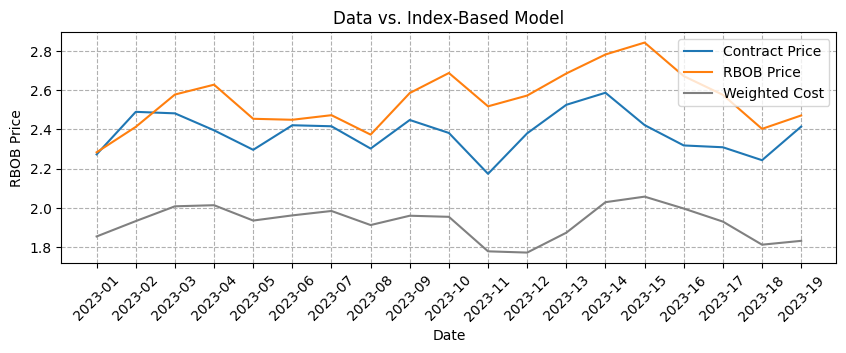

In [ ]:
week_previous_cost = 1
weight_interval = 10
contractPrice(df_weeklytrain, df_weeklyfcast, freq=week_previous_cost, n=weight_interval)

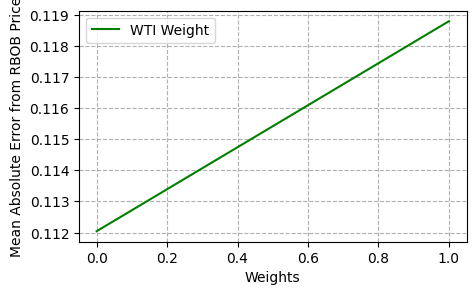



[Best weights in 19 day(s) mean previous cost]

WTI Weight: 0.0000, Brent Weight: 1.0000, Total Absolute Error: 2.1288 price, Mean Absolute Error: 0.1120 price



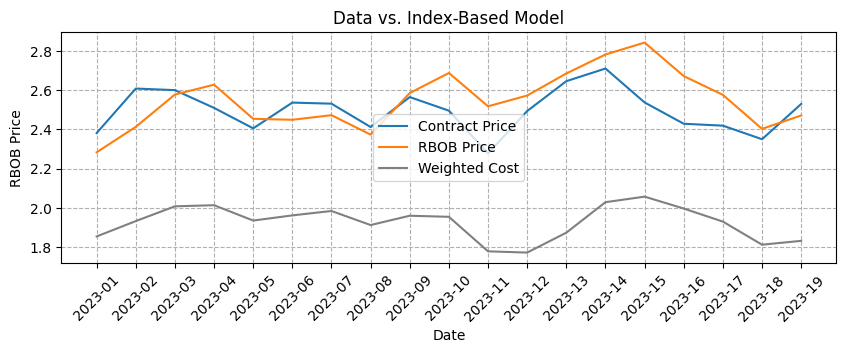

In [ ]:
week_previous_cost = 19
weight_interval = 10
contractPrice(df_weeklytrain, df_weeklyfcast, freq=week_previous_cost, n=weight_interval)

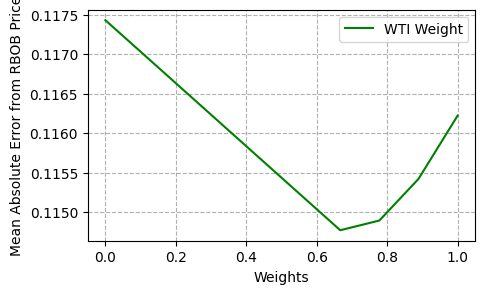



[Best weights in 23 day(s) mean previous cost]

WTI Weight: 0.6667, Brent Weight: 0.3333, Total Absolute Error: 2.1806 price, Mean Absolute Error: 0.1148 price



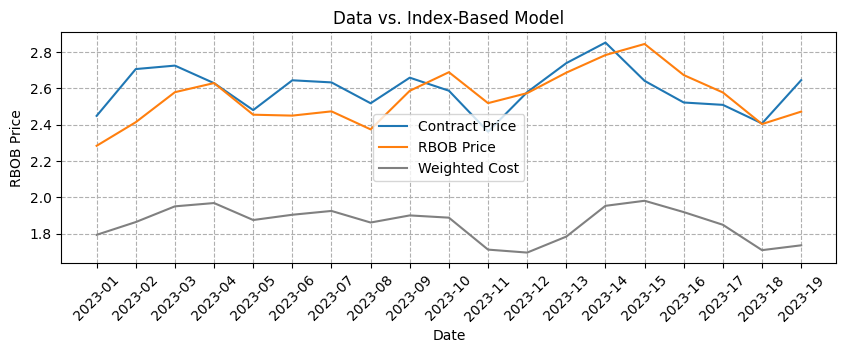

In [ ]:
week_previous_cost = 23
weight_interval = 10
contractPrice(df_weeklytrain, df_weeklyfcast, freq=week_previous_cost, n=weight_interval)

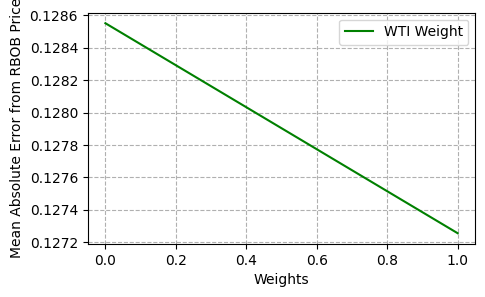



[Best weights in 24 day(s) mean previous cost]

WTI Weight: 1.0000, Brent Weight: 0.0000, Total Absolute Error: 2.4178 price, Mean Absolute Error: 0.1273 price



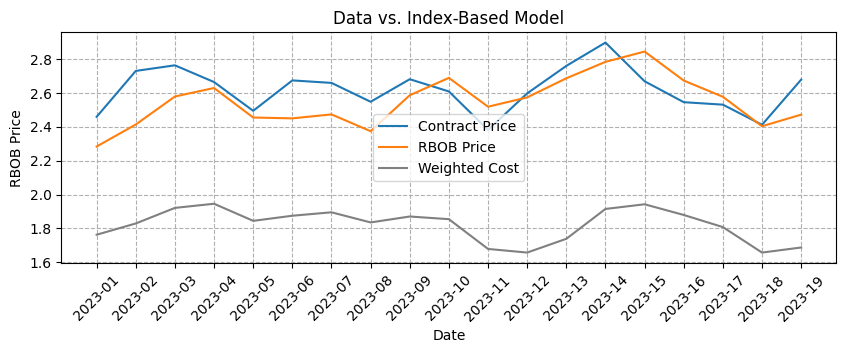

In [ ]:
week_previous_cost = 24
weight_interval = 10
contractPrice(df_weeklytrain, df_weeklyfcast, freq=week_previous_cost, n=weight_interval)